<a href="https://colab.research.google.com/github/327840386/lego-detection/blob/main/lego_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1, Loss: 0.6008800268173218
Epoch 2, Loss: 0.1658107042312622
Epoch 3, Loss: 0.7790185809135437
mAP: 0.6059607863426208


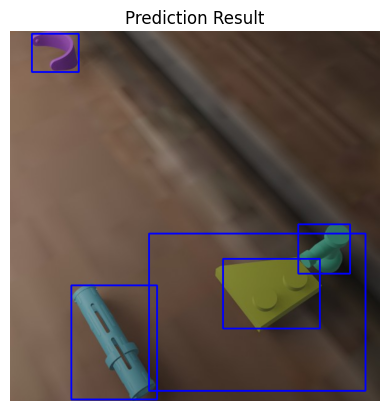

In [12]:
from google.colab import drive
# Mount Google Drive to access the dataset
# This allows you to access your Google Drive files in Colab

drive.mount('/content/drive')

# 2. Data Preparation
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torchvision.datasets as dset
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import cv2
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Define the dataset paths
# DATASET_PATH should point to the location of the dataset on Google Drive
DATASET_PATH = '/content/drive/My Drive/computer_vision/lego_dataset'
IMAGES_PATH = os.path.join(DATASET_PATH, 'images')
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, 'annotations')

# Create folders for train, validation, and test splits
os.makedirs('data/images/train', exist_ok=True)
os.makedirs('data/images/val', exist_ok=True)
os.makedirs('data/images/test', exist_ok=True)
os.makedirs('data/labels/train', exist_ok=True)
os.makedirs('data/labels/val', exist_ok=True)
os.makedirs('data/labels/test', exist_ok=True)

# Split the dataset and ensure that each image has corresponding annotations
images = [f for f in os.listdir(IMAGES_PATH) if f.endswith('.jpg')]
valid_images = []
for image in images:
    label_path = os.path.join(ANNOTATIONS_PATH, image.replace('.jpg', '.xml'))
    if os.path.exists(label_path):
        valid_images.append(image)

# Use only a subset of images for simplicity (reduce data size)
sample_size = min(200, len(valid_images))  # Use up to 200 images
sampled_images = random.sample(valid_images, sample_size)

train_imgs, val_test_imgs = train_test_split(sampled_images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(val_test_imgs, test_size=0.5, random_state=42)

# Move selected images to their corresponding folders
def move_files(file_list, source_folder, dest_folder):
    for file_name in file_list:
        shutil.copy(os.path.join(source_folder, file_name), dest_folder)

move_files(train_imgs, IMAGES_PATH, 'data/images/train')
move_files(val_imgs, IMAGES_PATH, 'data/images/val')
move_files(test_imgs, IMAGES_PATH, 'data/images/test')

# 3. Dataset Loader Definition
# Define image transformations for training and testing

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())  # Convert image to tensor
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))  # Random horizontal flip during training
    return T.Compose(transforms)

# Custom dataset class for loading LEGO images and annotations
class LegoDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root)))

    def __getitem__(self, idx):
        # Load image and corresponding annotations
        img_path = os.path.join(self.root, self.imgs[idx])
        label_path = os.path.join(ANNOTATIONS_PATH, self.imgs[idx].replace('.jpg', '.xml'))
        img = Image.open(img_path).convert("RGB")
        boxes = []
        tree = ET.parse(label_path)
        root = tree.getroot()
        # Extract bounding boxes from XML annotations
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            x_min = float(bbox.find('xmin').text)
            y_min = float(bbox.find('ymin').text)
            x_max = float(bbox.find('xmax').text)
            y_max = float(bbox.find('ymax').text)
            boxes.append([x_min, y_min, x_max, y_max])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64) * 1  # All objects labeled as 'lego'
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        masks = torch.zeros((len(boxes), img.height, img.width), dtype=torch.uint8)
        target = {"boxes": boxes, "labels": labels, "masks": masks, "image_id": image_id, "area": area, "iscrowd": iscrowd}
        # Apply transformations
        if self.transforms is not None:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

# 4. Define the Mask R-CNN Model
# Load pre-trained Mask R-CNN with ResNet-50 backbone
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
model.roi_heads.box_predictor.cls_score = torch.nn.Linear(1024, 2)  # Adjust to two classes (background and LEGO)

# 5. Training Settings
def collate_fn(batch):
    return tuple(zip(*batch))

if __name__ == "__main__":
    # Use GPU if available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Data loaders for training and validation
    train_dataset = LegoDataset('data/images/train', get_transform(train=True))
    val_dataset = LegoDataset('data/images/val', get_transform(train=False))
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=collate_fn)
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

    # Optimizer and Learning Rate Scheduler
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training Loop
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        for images, targets in train_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        lr_scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {losses.item()}")

    # 7. Model Evaluation (mAP)
    def evaluate_mAP(model, data_loader, device):
        model.eval()
        metric = MeanAveragePrecision()

        with torch.no_grad():
            for images, targets in data_loader:
                images = list(image.to(device) for image in images)
                outputs = model(images)

                # Convert outputs to a format suitable for torchmetrics
                preds = []
                gts = []

                for output, target in zip(outputs, targets):
                    pred = {
                        "boxes": output["boxes"].cpu(),
                        "scores": output["scores"].cpu(),
                        "labels": output["labels"].cpu()
                    }
                    gt = {
                        "boxes": target["boxes"].cpu(),
                        "labels": target["labels"].cpu()
                    }
                    preds.append(pred)
                    gts.append(gt)

                metric.update(preds, gts)

        # Compute and print mAP
        mAP_result = metric.compute()
        print("mAP:", mAP_result["map"].item())

    evaluate_mAP(model, val_data_loader, device)

    # 8. Inference and Visualization
    model.eval()
    img_path = f"data/images/test/{test_imgs[0]}"
    img = Image.open(img_path).convert("RGB")
    img_tensor = get_transform(train=False)(img).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)

    # Visualize the prediction result
    img_cv = cv2.imread(img_path)
    for box in prediction[0]['boxes']:
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(img_cv, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Prediction Result")
    plt.axis('off')
    plt.show()



